# Compare models trained on mixed class data

This compares several different models trained on **mixed** *longliner*,
*trawler* and *purse seiner* data.

**NOTE: this was somewhat unstable. Running multiple times yielded significantly different results, 
  depending the data split.  I set seeds everywhere and now the output is stable. However, this tells 
  me that we want more data!**

In [1]:
%matplotlib inline
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML

In [2]:
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [3]:
set(x_tran['mmsi'])

{367512180.0, 367512510.0, 367534310.0, 367721000.0}

In [4]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [5]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_lline.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_lline.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_lline.dtype)

In [6]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_trawl, xtrain_lline, xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_trawl, xcross_lline, xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([xtrain, xcross])

xtest = np.concatenate([xtest_trawl, xtest_lline, xtest_pseine, xtest_tran])

In [7]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel

untrained_models = [
    ('Logistic', LogisticModel(colspec=dict(windows=[43200]), order=6)),
    ('Logistic opt MSE', LogisticModel(colspec=dict(windows=[43200]), order=4, cross=3)),
#     ('Logistic (MW)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6)),
#     ('Logistic (MW/cross3)', LogisticModel(colspec=dict(windows=[1800, 3600, 10800, 21600, 43200, 86400]), order=6, cross=2)),
    ('Random Forest', RandomForestModel(colspec=dict(windows=[43200]))),
#     ('Random Forest (MW)', RandomForestModel(windows=[1800, 3600, 10800, 21600, 43200, 86400])),
#     ('Legacy', LegacyHeuristicModel(window=3600)),
#     ("Legacy (3 Hour)", LegacyHeuristicModel(window=10800)),
#     ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200)),
#     ("Legacy (24 Hour)", LegacyHeuristicModel(window=86400)),  
]

trained_models = [(name, train_model_on_data(mdl, train)) for (name, mdl) in untrained_models]

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 5284
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


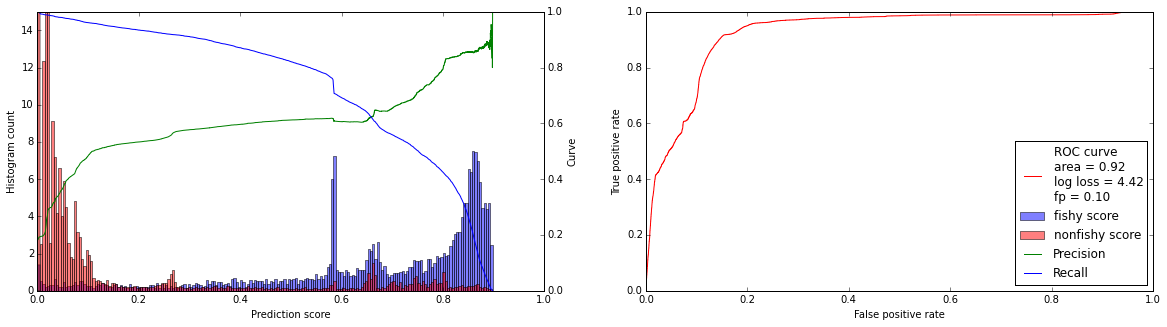

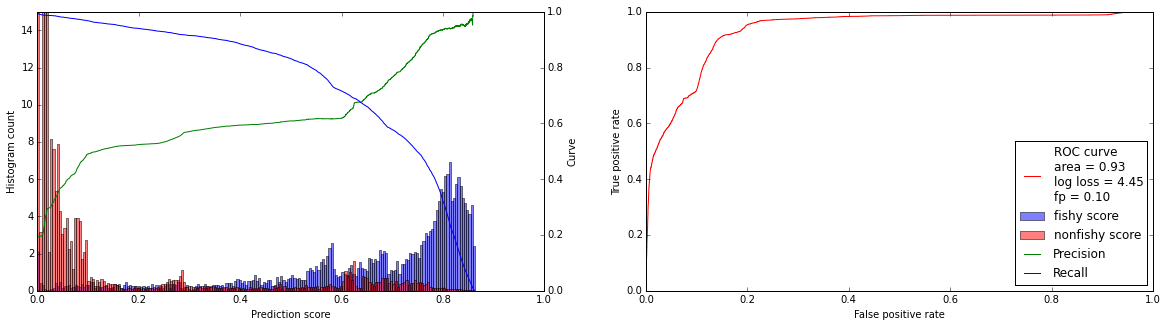

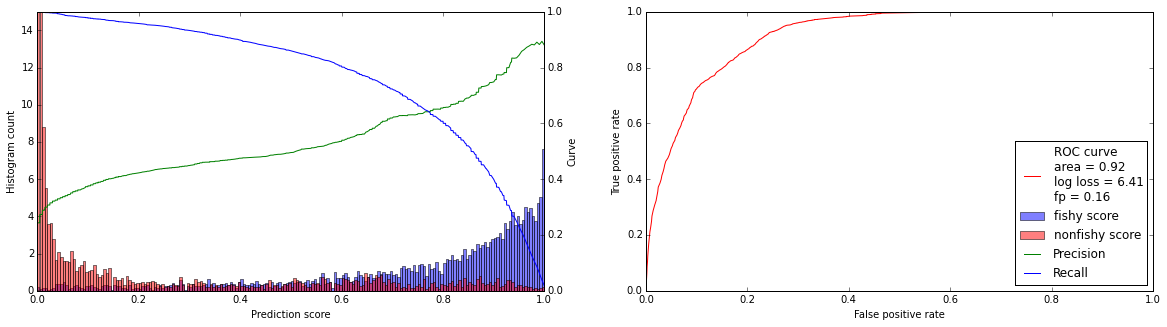

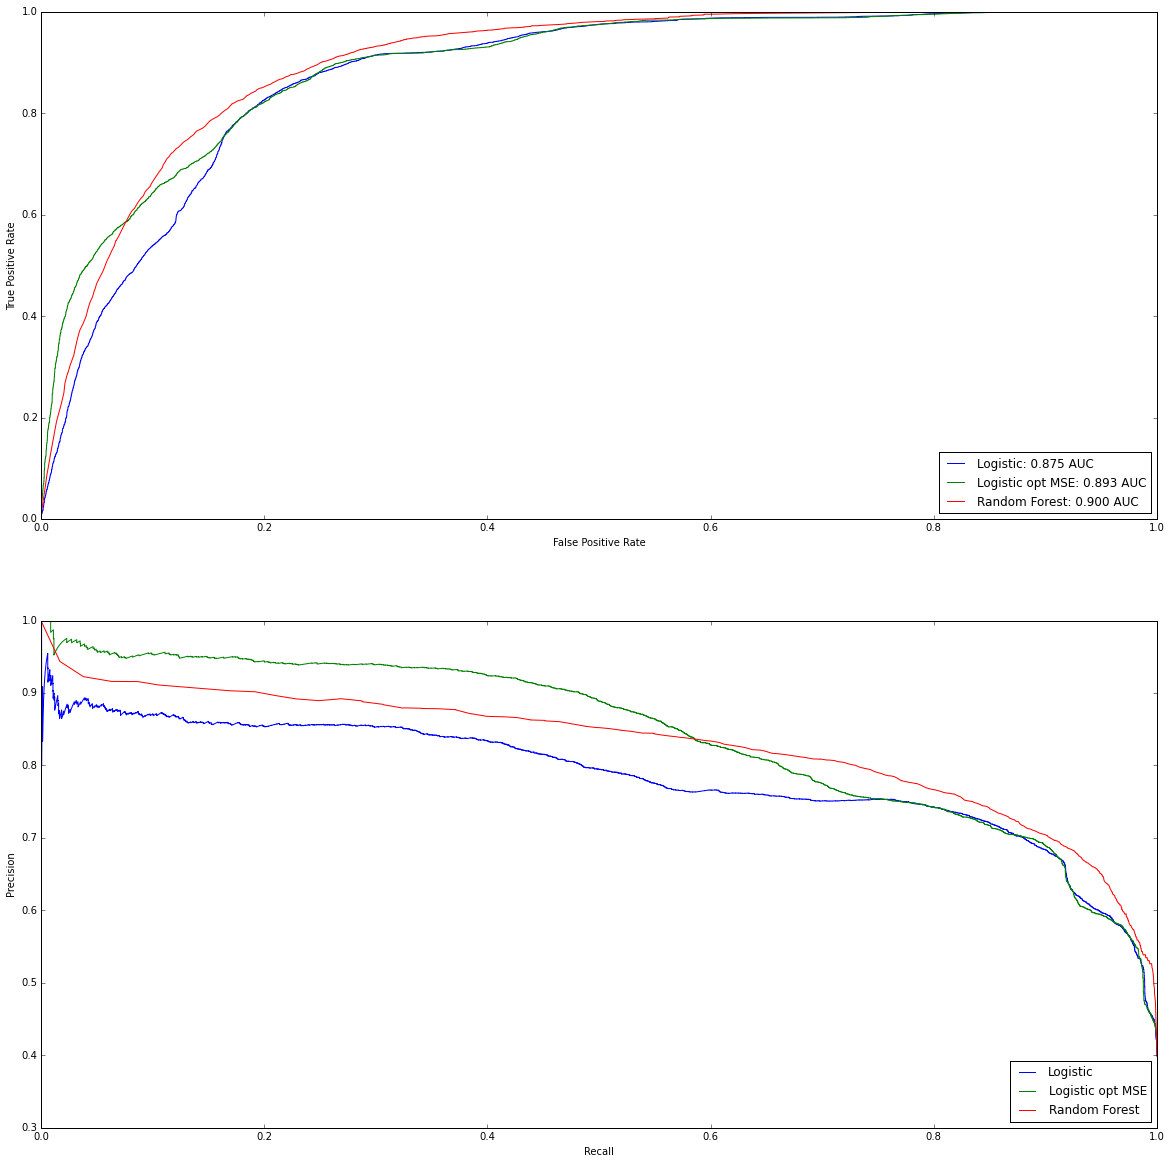

In [8]:
dataset = vessel_scoring.models.load_data()

display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in trained_models:
    spec = vessel_scoring.models.untrained_models[name]

    test_data = [dataset[name]['test'] for name in spec['data']]
    test_data = vessel_scoring.utils.concatenate_different_recarrays(test_data)   

    evaluate_model(mdl, test_data, name=name)

display(HTML("<h1>Overall comparison</h1>"))
compare_models(trained_models, xtest)

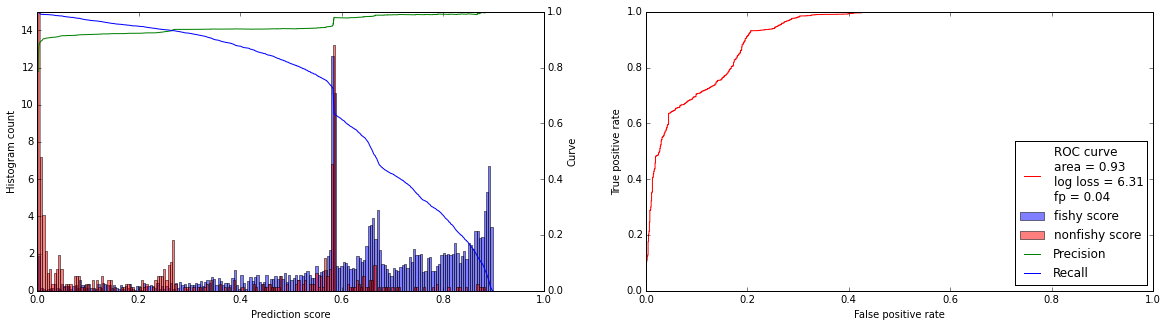

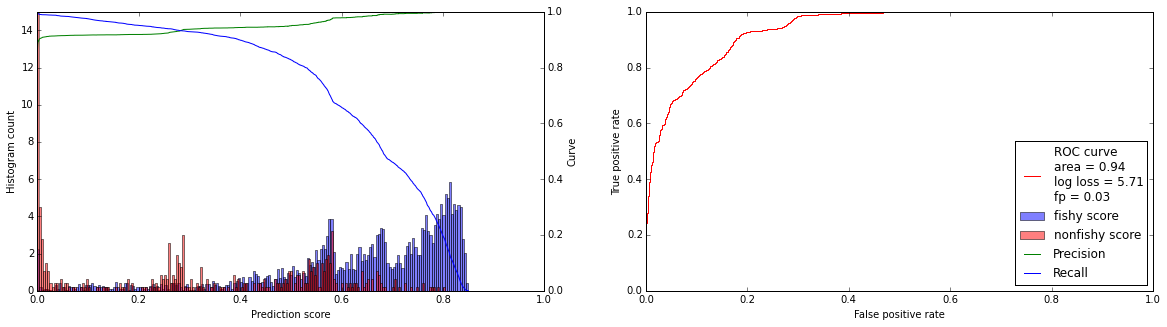

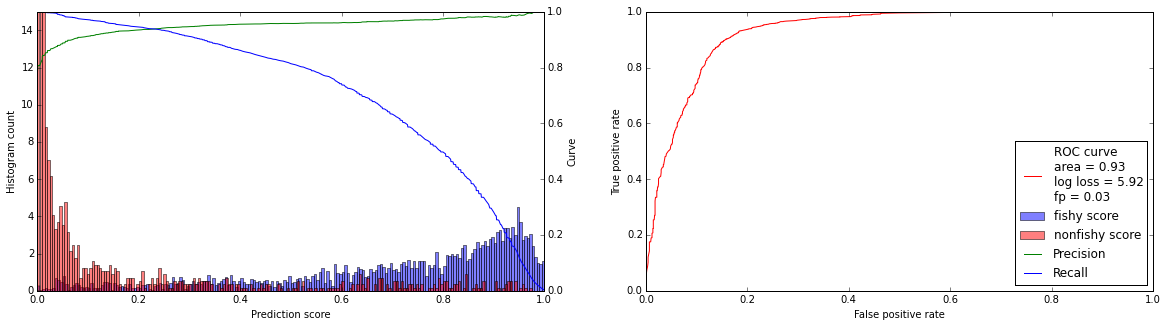

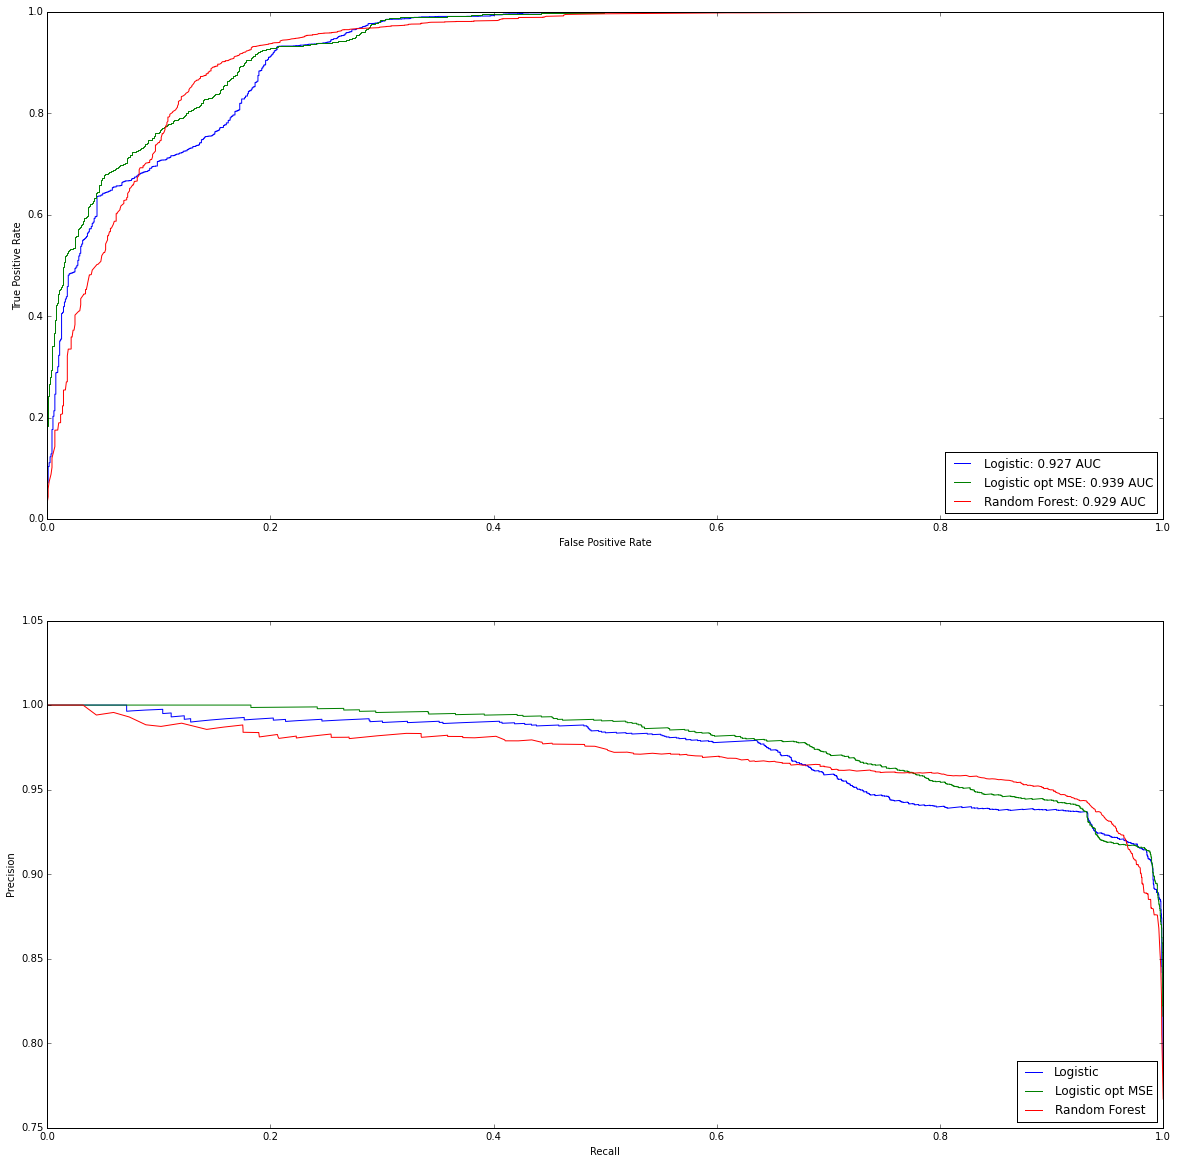

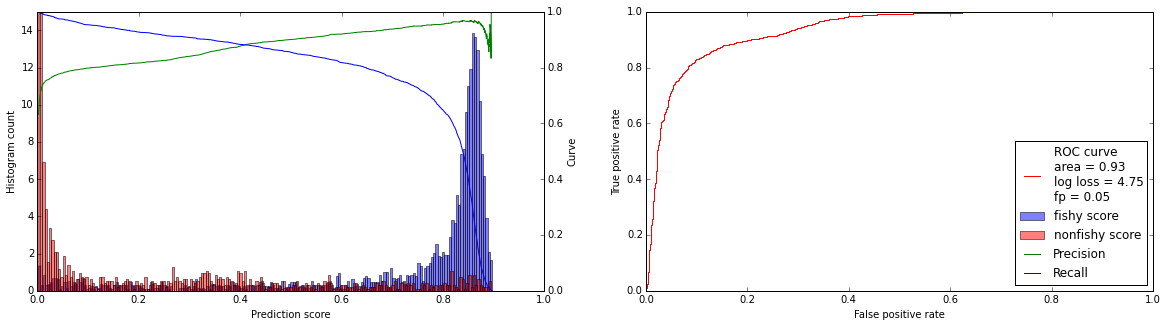

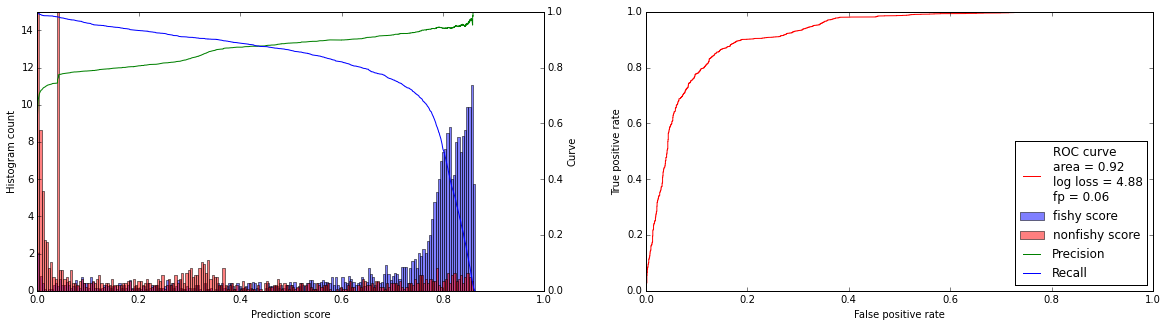

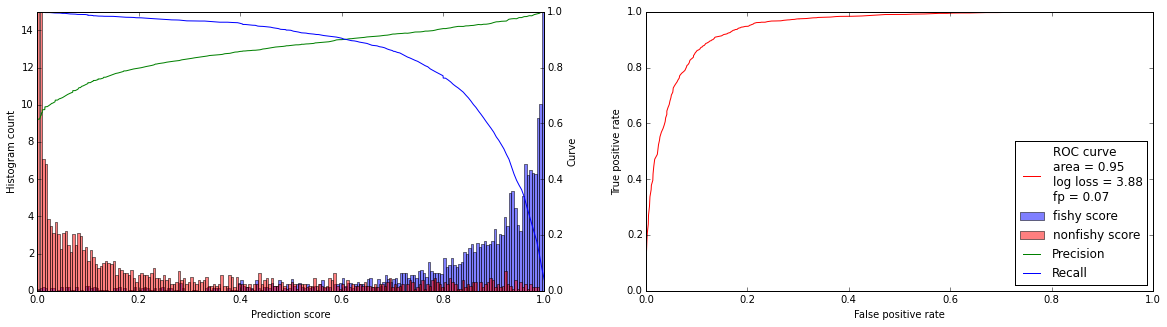

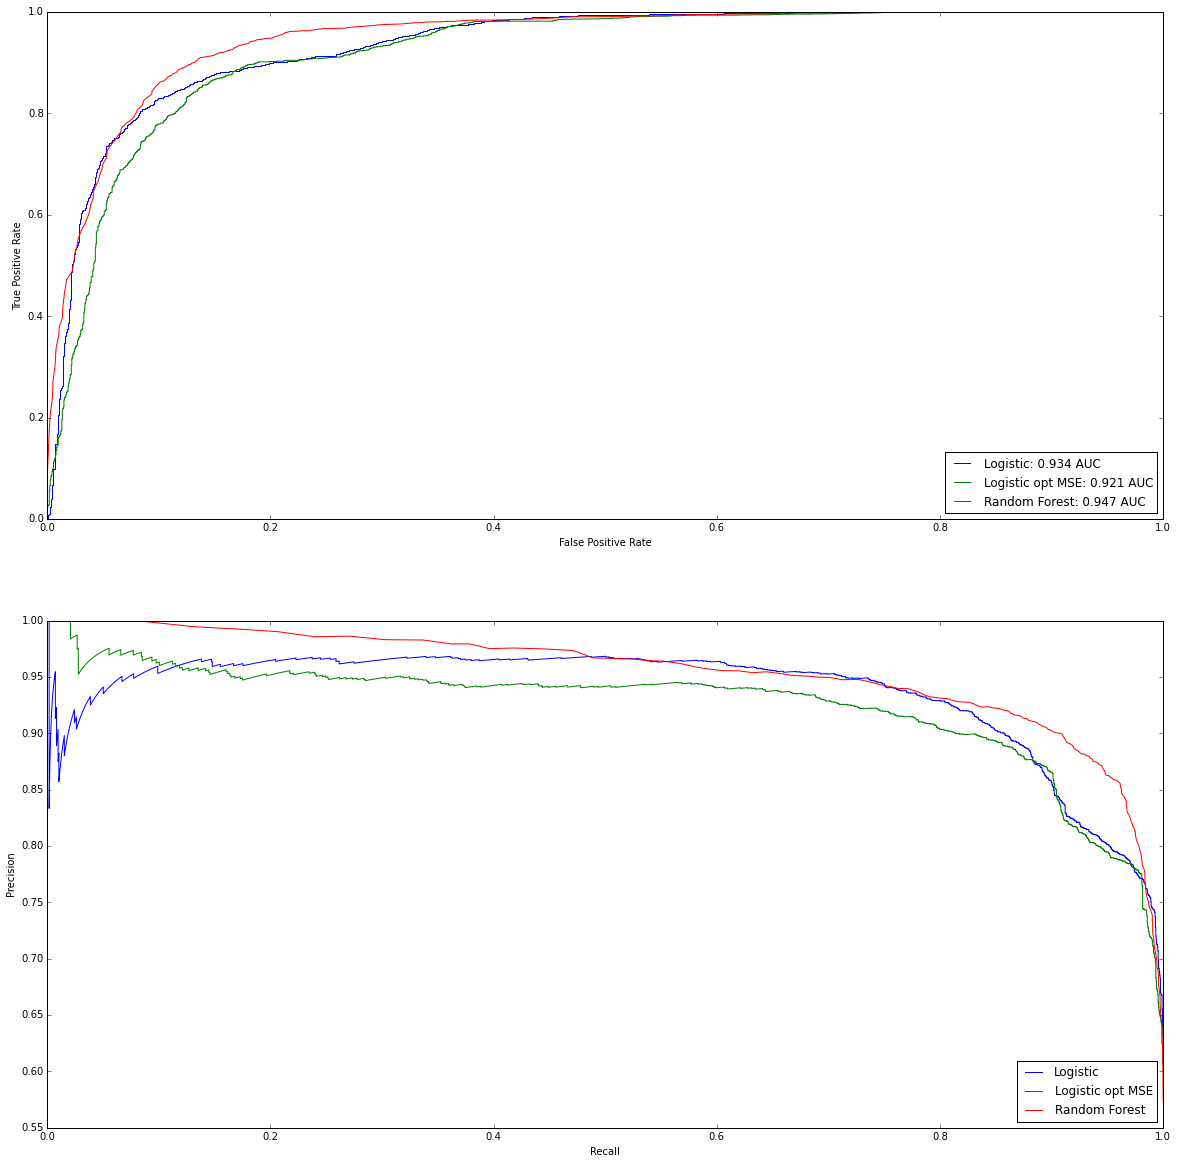

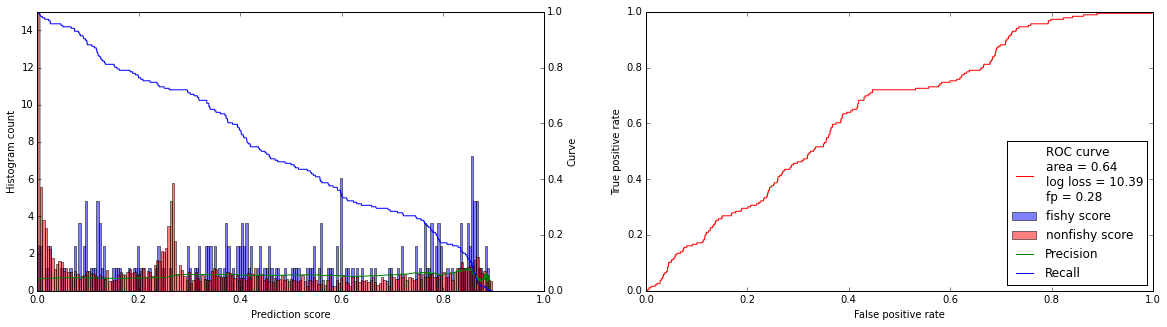

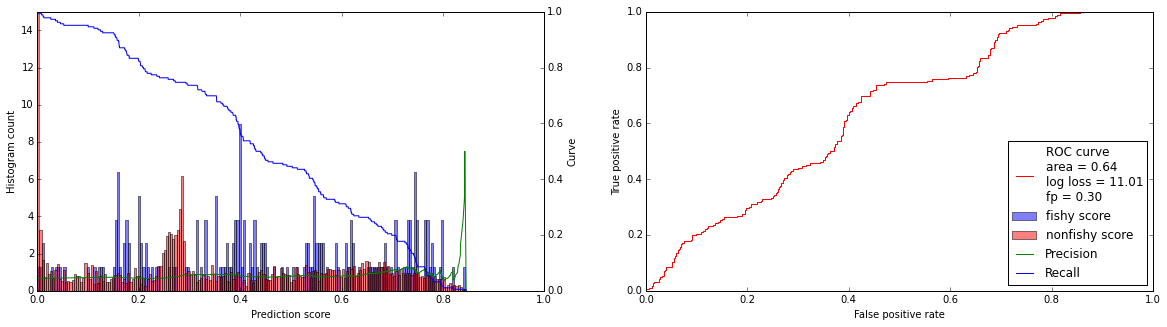

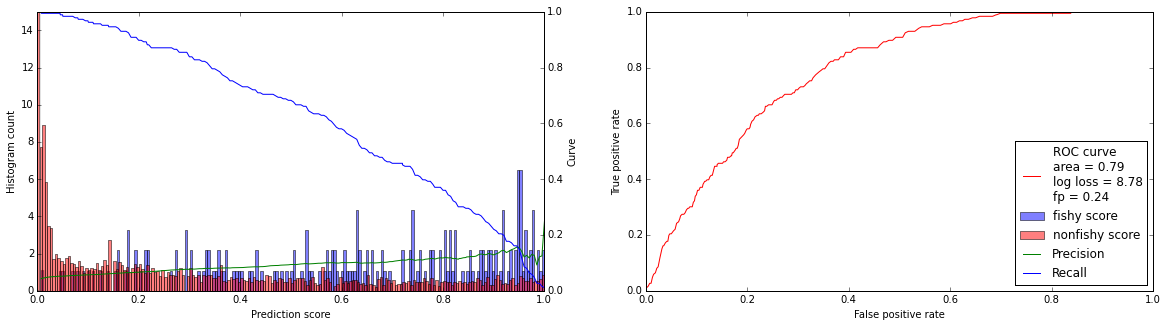

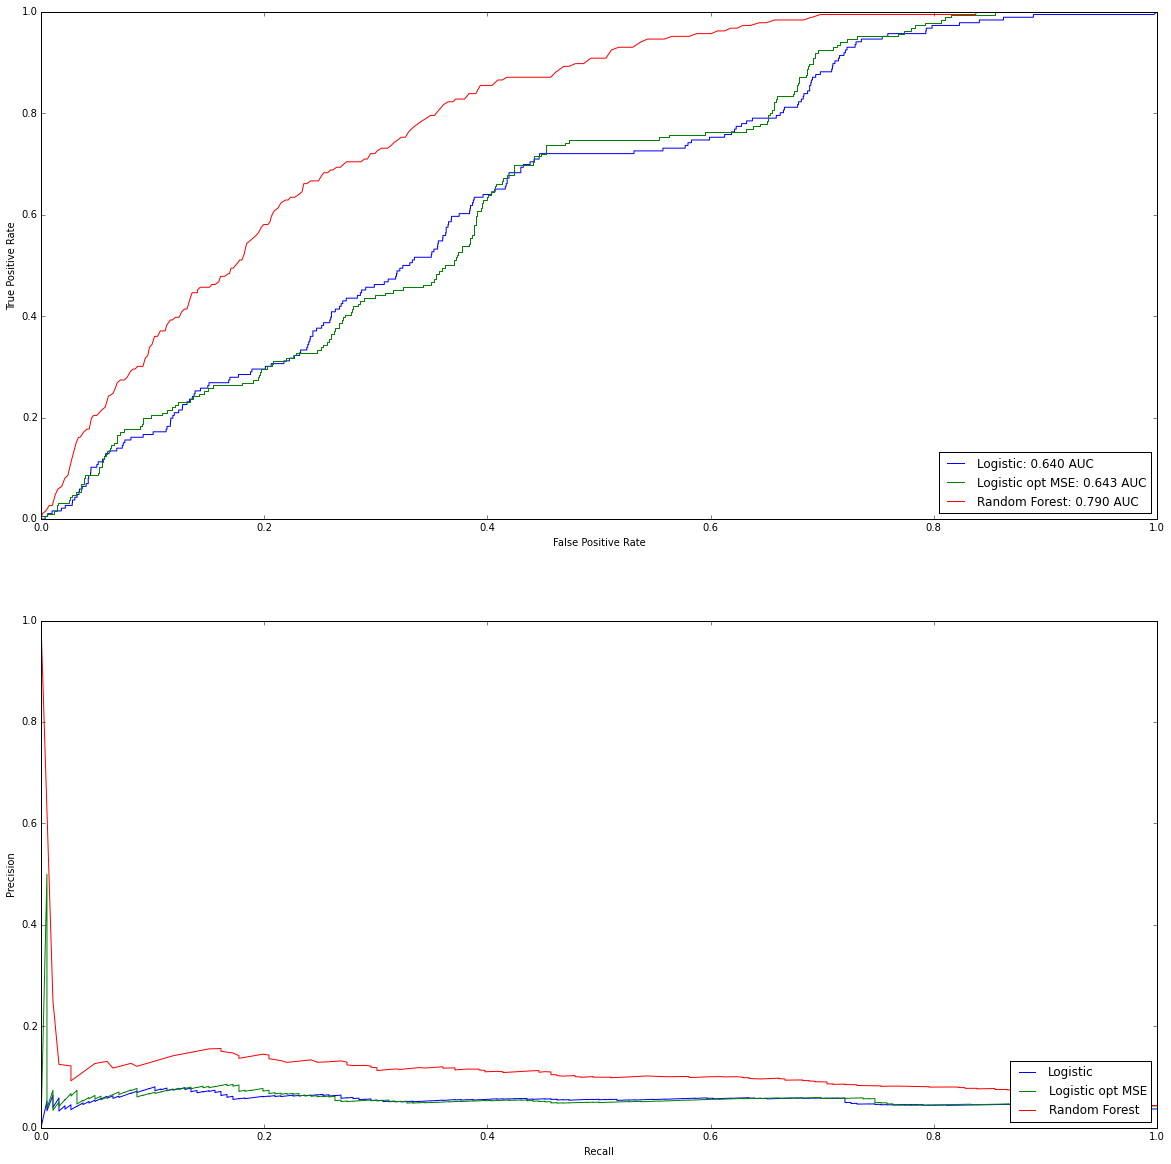

In [9]:
for vessel_class, xtest_class in  [("longliner", xtest_lline), 
                                   ("trawler", xtest_trawl), 
                                   ("purse seine", xtest_pseine)]:
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    for name, mdl in trained_models:
        evaluate_model(mdl, xtest_class, name=name)
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    compare_models(trained_models, xtest_class)

# How does this model do on the slow transit tracks?

In [10]:
for name, mdl in trained_models:
    p = mdl.predict_proba(xtest_tran)[:,1]
    print name, p.mean(), (p > 0.5).mean()

Logistic 0.0886199351396 0.0756972111554
Logistic opt MSE 0.0822863627173 0.0756972111554
Random Forest 0.175195389539 0.189907038513


## What about the new transit tracks?

In [11]:
from vessel_scoring import data
x_tran2 = np.load('datasets/new_transits.measures.npz')['x']

# We are somehow getting an extra, 0 MMSI. Why?
# Results are totally bogus
x_tran2 = x_tran2[x_tran2['mmsi'] != 0]

x_tran2 = x_tran2[np.isnan(x_tran2['speed']) != True]

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for name, mdl in trained_models:
    p = mdl.predict_proba(x_tran2)[:,1]
    print name, p.mean(), (p > 0.5).mean()

Transit tracks for [367512170.0, 412420562.0, 412420979.0, 412420992.0]

Logistic 0.0427038214113 0.0252675003223
Logistic opt MSE 0.0403166260204 0.0260409952301
Random Forest 0.0829415152242 0.0547892226376


## Where are the false positives?

The important thing is that the false positives are not evenly spaced out, so they shouldn't
show up as track like.

FP rate for MMSI 367512170 is: 0.0226345840131
FP rate for MMSI 412420562 is: 0.0582287308229
FP rate for MMSI 412420979 is: 0.0219677055952
FP rate for MMSI 412420992 is: 0.00372516556291


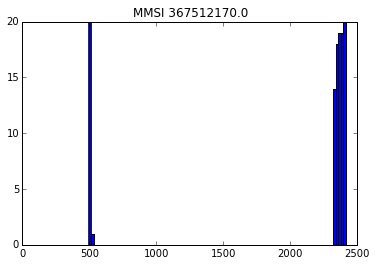

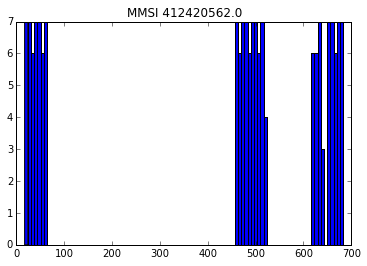

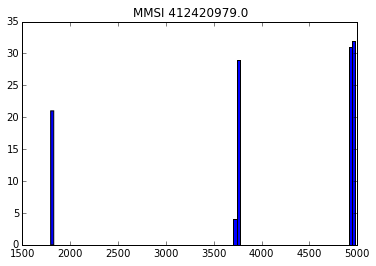

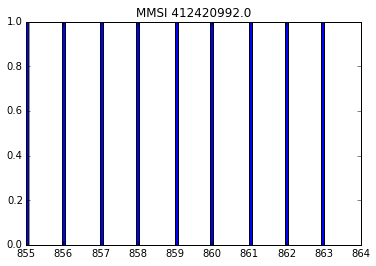

In [12]:
import matplotlib.pyplot as plt
mmsi = sorted(set(x_tran2['mmsi']))

name, mdl = trained_models[1]

for m in mmsi:
    subset = x_tran2[x_tran2['mmsi'] == m]
    n = len(subset)
    locs = np.arange(n)[mdl.predict_proba(subset)[:,1] > 0.5]
    print "FP rate for MMSI", int(m), "is:", len(locs) / float(n)
    plt.figure()
    plt.title("MMSI {0}".format(m))
    plt.hist(locs, bins=100)

## Verify that we get same results when training using saved models

When loading from saved models we still get the same result

In [13]:
reload(vessel_scoring.logistic_model)
from vessel_scoring.logistic_model import LogisticScorer
from glob import glob
import json
paths = glob("vessel_scoring/models/Logistic*.json")

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for pth in paths:
    with open(pth) as f:
        args = json.load(f)['args']
    mdl = LogisticScorer(**args)
    p = mdl.predict_proba(x_tran2)[:,1]
    print pth, p.mean(), (p > 0.5).mean()

Transit tracks for [367512170.0, 412420562.0, 412420979.0, 412420992.0]

vessel_scoring/models/Logistic opt MSE.json 0.0226673934397 0.00560783808173
vessel_scoring/models/Logistic--Longliner.json 0.0162156632081 0.00328735335826
vessel_scoring/models/Logistic--Purse seine.json 0.00421920982857 0.00257831635942
vessel_scoring/models/Logistic--Trawler.json 0.0143522422876 0.0026427742684
vessel_scoring/models/Logistic.json 0.0229839756136 0.00457651153797


## Results when not training with transit data.

    Logistic 0.838618506196 0.984949092519
    Logistic opt MSE 0.826260344662 0.986277113767
    Random Forest 0.718120849934 0.885790172643
    Legacy 0.623862134036 0.773351040283
    Legacy (12 Hour) 0.66843170167 0.912793271359
    
**If we don't train on these slow transit tracks, results are pretty awful**

# Dumping the model and using LogisticScorer

LogisticScorer is a simple reimplementation of the prediciton part of 
the logistic predictor. This way we can dump out the parameters from 
the model and then use it in the pipeline where we potentially can
optimize it for that particular application.

0.862885389691
0.862885389691
0.862885389691


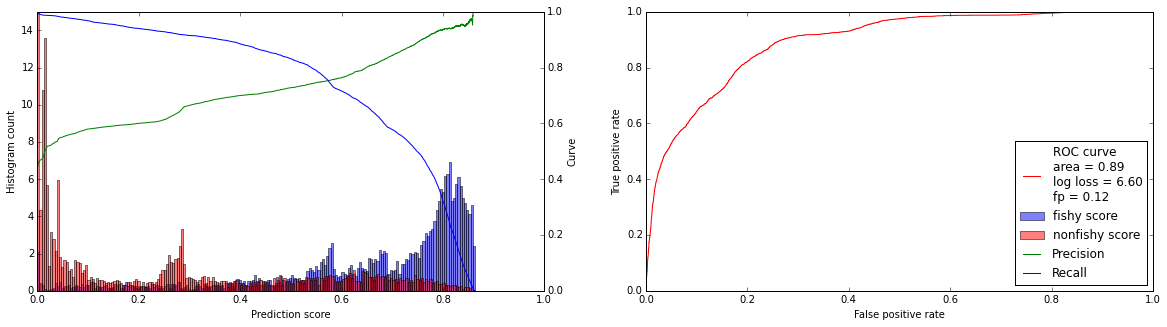

In [14]:
from vessel_scoring.logistic_model import LogisticScorer

scorer = LogisticScorer(**trained_models[1][1].dump_dict()['args'])

print scorer.fishing_score(xtest).max()
print scorer.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(scorer, xtest)

0.862885389691
0.862885389691


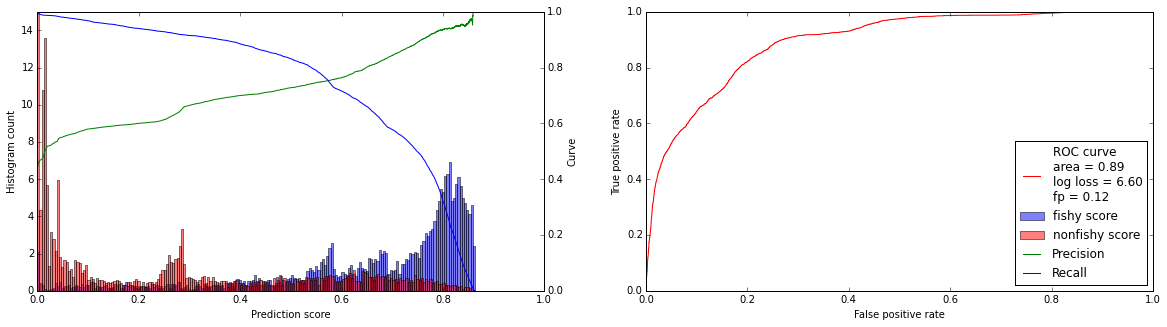

In [15]:
# Verify that we can also load LogisticModels from dumped LogisticModels
# Had to abuse sklearn interface a bit for this to work
import imp, vessel_scoring.logistic_model
imp.reload(vessel_scoring.logistic_model)


from vessel_scoring.logistic_model import LogisticModel


model = LogisticModel(**trained_models[1][1].dump_dict()['args'])

print model.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(model, xtest)

In [16]:
import json

trained_models[1][1].dump_dict()

{'args': {'coef': [[-5.8840013280771739,
    12.981576240908442,
    14.212363019640048,
    16.672478091539517,
    -12.12634704939981,
    1.6896109801092756,
    -2.5013977091000652,
    6.623859113922121,
    -5.1125771878167239,
    12.238030575092539,
    -5.3667832735586076,
    -3.2112162032280178,
    -13.525276771973269,
    1.4989757231156011,
    -3.1337768880658055,
    -14.574633266385359,
    -5.0005255948565654,
    -10.014379366428269,
    -17.342003558731918,
    -1.6743170210177949,
    -2.2600177000943504]],
  'colspec': {'measures': [],
   'window_measures': ['measure_speedavg',
    'measure_speedstddev',
    'measure_coursestddev'],
   'windows': [43200]},
  'cross': 3,
  'intercept': [-8.8590535465668676],
  'order': 4},
 'model': 'vessel_scoring.logistic_model.LogisticModel'}

# Load existing models and evaluate

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 5284
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


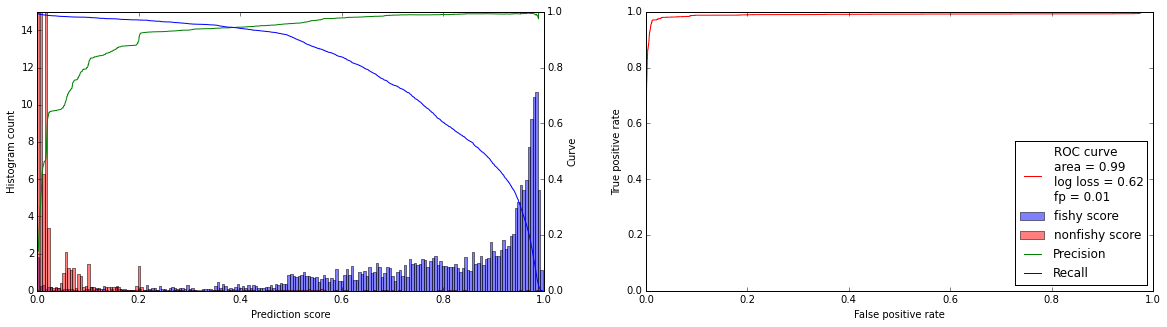

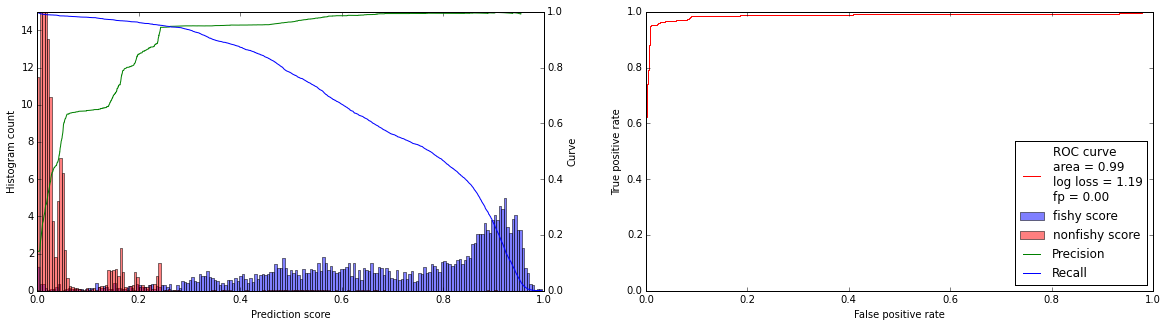

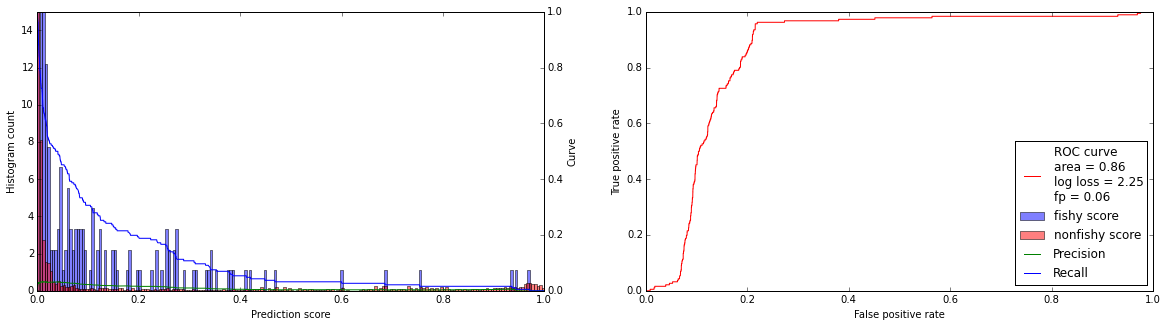

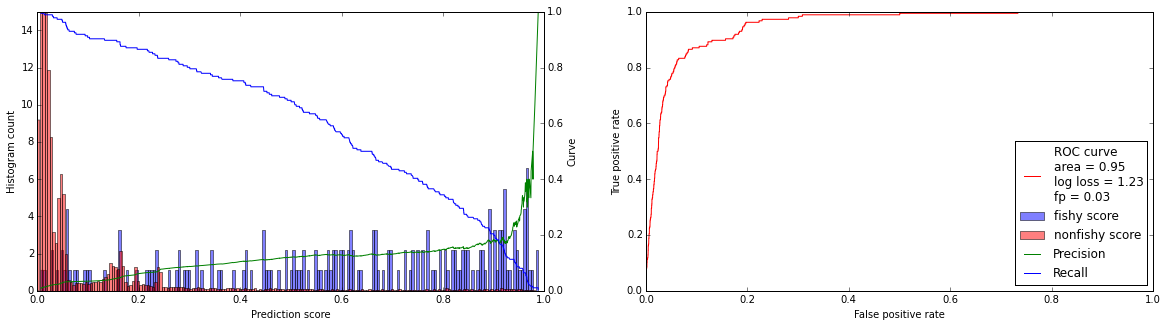

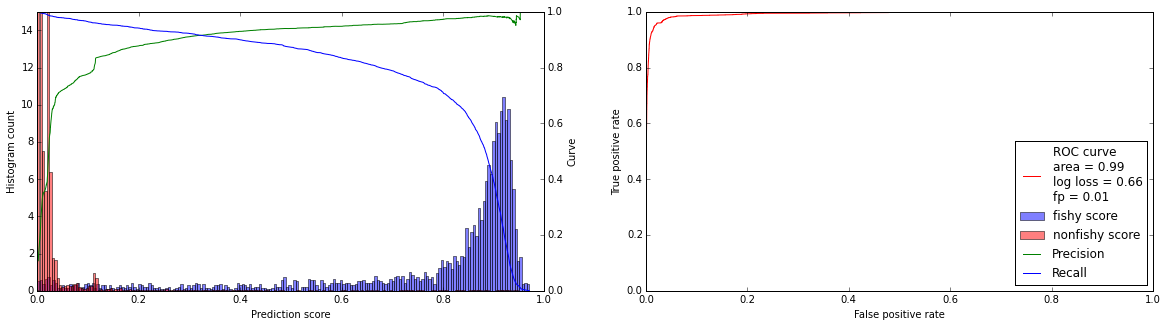

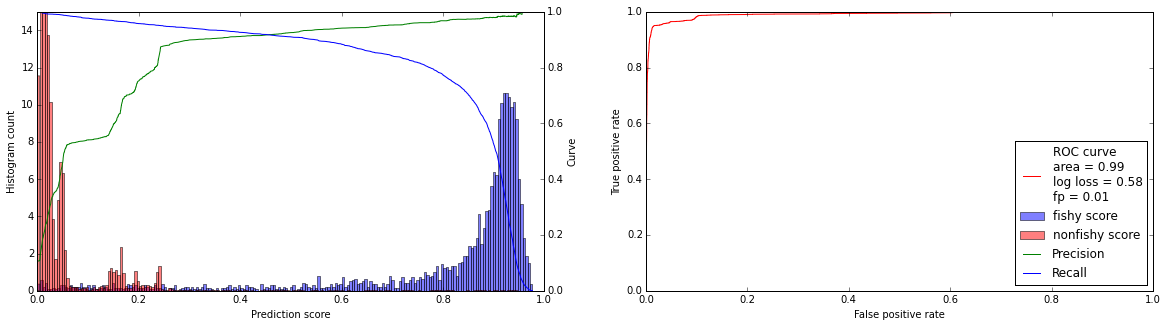

In [17]:
import vessel_scoring.models
loaded_models = vessel_scoring.models.load_models()
dataset = vessel_scoring.models.load_data()

display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in loaded_models.iteritems():
    if '--' not in name:
        continue
        
    spec = vessel_scoring.models.untrained_models[name]

    test_data = [dataset[dataname]['test'] for dataname in spec['data']]
    test_data = vessel_scoring.utils.concatenate_different_recarrays(test_data)   

    method, dataname = name.split("--")
        
    evaluate_model(mdl, test_data, name="%s trained and tested on %s" % (method, dataname))

    generic_model = loaded_models[name.split("--")[0]]

    evaluate_model(generic_model, test_data, name="Generic %s tested on %s" % (method, dataname))


In [18]:
x = np.load("datasets/kristina_longliner.npz")['x']

In [19]:
mmsis = np.unique(x['mmsi'])

mmsidata = {}
for mmsi in mmsis:
    mmsix = x[x['mmsi'] == mmsi]
    mmsidata[mmsi] = mmsix['timestamp'].max() - mmsix['timestamp'].min()


In [20]:
def f(x):
    y = int(np.floor(x / 365. / 24. / 60. / 60.))
    x = x - y * 365. * 24. * 60. * 60.
    d = int(np.floor(x / 24. / 60. / 60.))
    x = x - d * 24. * 60. * 60.
    h = int(np.floor(x / 60. / 60.))
    x = x - h * 60. * 60.
    m = int(np.floor(x / 60.))
    s = x - m * 60.
    return "%s years %s days %s:%s:%s" % (y, d, h, m, s)

for mmsi, t in mmsidata.iteritems():
    print "%s: %s" % (mmsi, f(t))

224068000.0: 1 years 192 days 12:49:58.0
273846400.0: 1 years 213 days 4:0:32.0
224108130.0: 1 years 172 days 2:50:54.0
431154000.0: 1 years 212 days 15:37:54.0
273844100.0: 1 years 67 days 12:4:38.0
273310630.0: 1 years 213 days 23:22:40.0
224175430.0: 1 years 212 days 23:53:7.0
224241000.0: 1 years 198 days 14:14:47.0
224098250.0: 1 years 206 days 1:58:56.0
273842800.0: 1 years 210 days 23:35:17.0
259329000.0: 1 years 213 days 23:35:51.0
273315570.0: 1 years 212 days 16:9:27.0
273313640.0: 1 years 87 days 11:22:25.0
224259000.0: 1 years 213 days 22:59:24.0
273845700.0: 1 years 184 days 13:50:37.0
366820000.0: 1 years 212 days 13:44:19.0
432226000.0: 1 years 213 days 22:44:43.0
